<a href="https://colab.research.google.com/github/FaridRash/IGNIS/blob/main/MA_SNR_Visualization_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Libraries

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

#Github

In [ ]:
!git clone https://github.com/FaridRash/IGNIS

fatal: destination path 'IGNIS' already exists and is not an empty directory.


In [ ]:
!rm -rf /content/IGNIS/FoV\ visualization
!rm -rf /content/IGNIS/Notebooks/
!rm -rf /content/IGNIS/Reports/
!rm -rf /content/IGNIS/Requests/
!rm -rf /content/IGNIS/SNR\ Visualization

#Dataset

In [ ]:
df = pd.read_csv("/content/IGNIS/Dataset/df_excel_with_temperature.csv")
df.head()

,Altitude,Theta,Hour,Month,Day,GSD,North,South,West,East,Background Temperature
0,461.218874,21.299047,02:00,1,2,76.025089,40.829036,40.828186,14.144160,14.145534,286.143799
1,462.767619,12.416525,02:00,1,5,76.280377,40.829036,40.828186,14.144157,14.145531,287.206543
2,463.422734,14.037020,02:00,1,5,76.388363,40.829036,40.828186,14.144156,14.145530,287.206543
3,466.582339,22.475595,15:00,1,5,76.909177,40.829036,40.828186,14.144150,14.145524,288.963867
4,466.012605,13.759815,15:00,1,5,76.815265,40.829036,40.828186,14.144151,14.145525,288.963867


In [ ]:
df['Altitude'] = df['Altitude'] * 1000

#Constants

In [ ]:
c1 = 3.7418e8
c2 = 1.4388e4
h = 6.626e-34
c = 3e8

In [ ]:
epsilon = 0.95
tau_0 = 0.89
eta = 0.7
t = 0.01
focal_length = 72.8
F_number = 1.05
D = (focal_length / F_number) / 1000
NEDT = 0.0441 # NEDT = 44.1mK
lambda_range = np.arange(8, 14.1, 0.1)
delta_lambda = 0.1

#Variables

In [ ]:
tau_a = 0.5
Tt = 433.15
At = 100

#Functions

In [ ]:
def compute_sT(T):
    M_lambda = c1 / (lambda_range**5 * (np.exp(c2 / (lambda_range * T)) - 1))
    E_lambda = epsilon * M_lambda
    S_lambda = lambda_range * E_lambda * tau_a * tau_0 * eta * delta_lambda
    S_sum = np.sum(S_lambda)
    return S_sum

In [ ]:
def compute_s(R, theta_deg, A0, S_sum):
  cos_theta = np.cos(np.deg2rad(theta_deg))
  S_total = (D**2 * t * cos_theta * A0) / (4 * R**2 * h * c) * S_sum
  return S_total

#Sb

In [ ]:
df["Background Area"] = df["GSD"]**2
df['Sum of Background'] = df['Background Temperature'].apply(compute_sT)
df["Background Signal"] = compute_s(df["Altitude"], df["Theta"], df["Background Area"], df["Sum of Background"])

#SNEDT

In [ ]:
df["NEDT Temp"] = df["Background Temperature"] + NEDT
df['Sum of NEDT'] = df['NEDT Temp'].apply(compute_sT)
df["NEDT S"] = df['Sum of NEDT'] - df['Sum of Background']
df["NEDT Signal"] = compute_s(df["Altitude"], df["Theta"], df["Background Area"], df["NEDT S"])

#Smix

In [ ]:
s_Tt= compute_sT(Tt)
print(f'St: {s_Tt:.2f}')

St: 2322.84


In [ ]:
df["Target Signal"] = compute_s(df["Altitude"], df["Theta"], 100, s_Tt)
df["Mix Signal"] = (df["Background Signal"] * (1 - (At/df['Background Area']))) + df["Target Signal"]

#SNR

In [ ]:
df["SNR"] = (df["Mix Signal"] - df['Background Signal']) / df["NEDT Signal"]

#Visualization

In [ ]:
top_10_snr = df.nlargest(10, 'SNR')
print(top_10_snr[['Altitude', 'Theta', 'Hour', 'Day', 'Month',  'Background Temperature',  'SNR']])

           Altitude      Theta   Hour  Day  Month  Background Temperature  \
1124  200498.988550  30.063427  03:00   23      9              292.987305   
1125  200879.079888  34.380576  03:00   23      9              292.987305   
1123  216994.808789  38.488131  16:00   21      9              295.946045   
1122  217520.348261  31.291111  16:00   21      9              295.946045   
1121  239493.478277   5.665667  03:00   18      9              292.074219   
1120  244791.723498  33.771153  16:00   16      9              294.028076   
1119  248021.537369  22.927472  16:00   15      9              295.453125   
1118  248510.443723  32.972566  16:00   15      9              295.453125   
1116  269170.008125  35.842732  03:00    7      9              297.895020   
1117  269607.897047  28.672916  03:00    7      9              297.895020   

             SNR  
1124  477.936656  
1125  476.129721  
1123  391.936228  
1122  390.044642  
1121  339.167203  
1120  316.115627  
1119  302.025710  


In [ ]:
bottom_10_snr = df.nsmallest(10, 'SNR')
print(bottom_10_snr[['Altitude', 'Theta', 'Hour', 'Day', 'Month',  'Background Temperature', 'SNR']])

          Altitude      Theta   Hour  Day  Month  Background Temperature  \
125  457301.197415  14.332015  15:00   29      7              303.256348   
117  461676.520041  14.821779  15:00   16      7              301.649902   
126  456669.357025  15.628523  15:00   29      7              303.256348   
118  461235.989387  16.810330  15:00   16      7              301.649902   
131  461127.533195  17.674909  02:00   11      8              301.613525   
130  460787.860901  14.778970  02:00   11      8              301.613525   
113  461772.338387  10.082570  15:00   11      7              301.280518   
114  461426.098923  22.925995  15:00   11      7              301.280518   
132  449799.996464   5.236456  15:00   11      8              304.031982   
133  449145.284722  21.605575  15:00   11      8              304.031982   

           SNR  
125  79.923884  
117  80.140503  
126  80.145200  
118  80.293662  
131  80.371017  
130  80.489553  
113  80.508968  
114  80.629836  
132  81.74

In [ ]:
fig = px.scatter_3d(df, x='Theta', y='Altitude', z="SNR",
                    color="SNR", title="SNR vs Theta and Altitude")
fig.show()


<Figure size 1000x600 with 0 Axes>

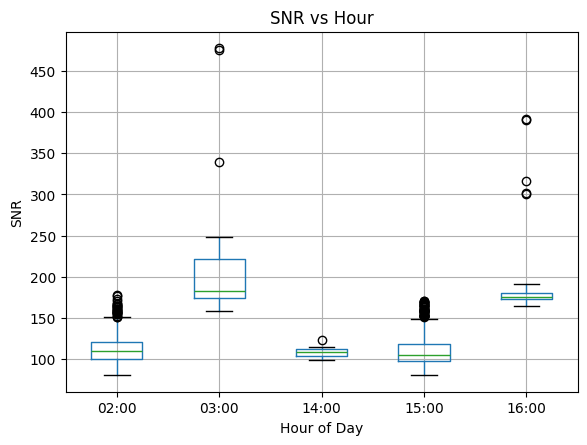

In [ ]:
plt.figure(figsize=(10, 6))
df.boxplot(column='SNR', by='Hour')
plt.title('SNR vs Hour')
plt.xlabel('Hour of Day')
plt.ylabel('SNR')
plt.suptitle('')
plt.show()

<Figure size 1000x600 with 0 Axes>

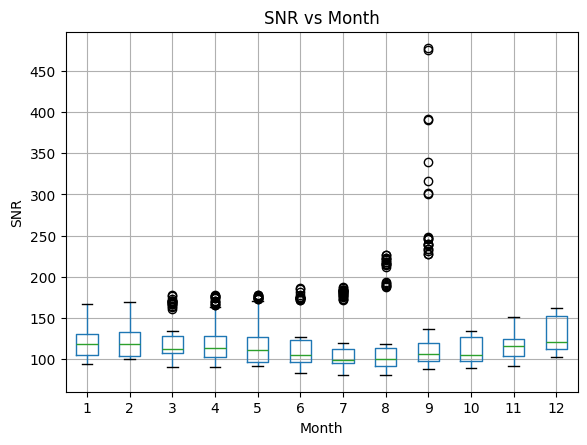

In [ ]:
plt.figure(figsize=(10, 6))
df.boxplot(column='SNR', by='Month')
plt.title('SNR vs Month')
plt.xlabel('Month')
plt.ylabel('SNR')
plt.suptitle('')
plt.show()

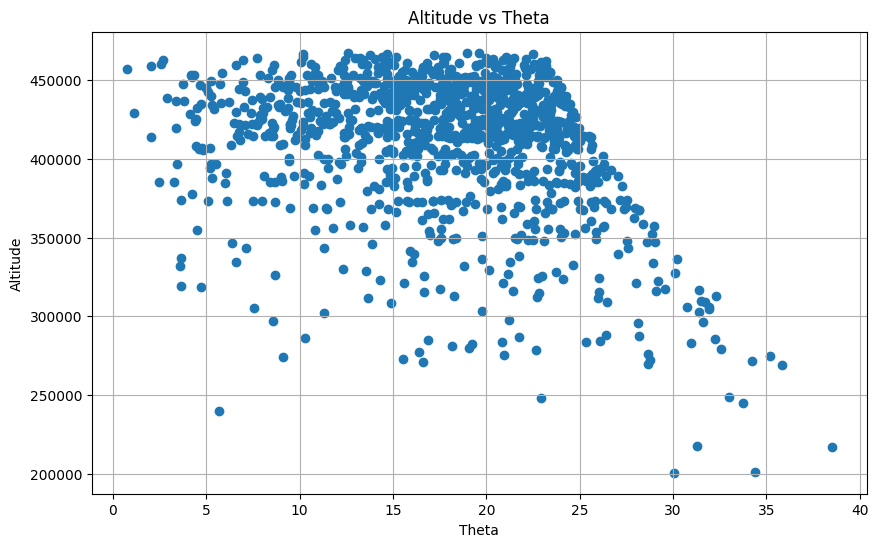

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df['Theta'], df['Altitude'])
plt.xlabel('Theta')
plt.ylabel('Altitude')
plt.title('Altitude vs Theta')
plt.grid(True)
plt.show()

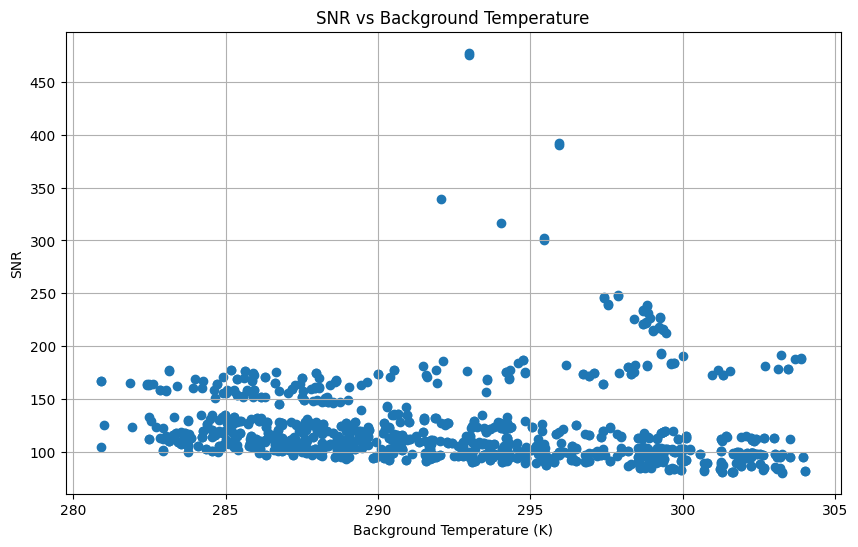

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df['Background Temperature'], df['SNR'])
plt.xlabel('Background Temperature (K)')
plt.ylabel('SNR')
plt.title('SNR vs Background Temperature')
plt.grid(True)
plt.show()

#ML

In [ ]:
# prompt: check df for missing data and show me the index of them

missing_data = df.isnull().sum()
print("Missing data per column:")
print(missing_data[missing_data > 0])

for col in df.columns:
    if df[col].isnull().sum() > 0:
        print(f"\nIndex of missing data in column '{col}':")
        print(df[df[col].isnull()].index.tolist())

Missing data per column:
Background Temperature    1
Sum of Background         1
Background Signal         1
NEDT Temp                 1
Sum of NEDT               1
NEDT S                    1
NEDT Signal               1
Mix Signal                1
SNR                       1
dtype: int64

Index of missing data in column 'Background Temperature':
[350]

Index of missing data in column 'Sum of Background':
[350]

Index of missing data in column 'Background Signal':
[350]

Index of missing data in column 'NEDT Temp':
[350]

Index of missing data in column 'Sum of NEDT':
[350]

Index of missing data in column 'NEDT S':
[350]

Index of missing data in column 'NEDT Signal':
[350]

Index of missing data in column 'Mix Signal':
[350]

Index of missing data in column 'SNR':
[350]


In [ ]:
df_cleaned = df.dropna()

In [ ]:
# Fix: Convert 'Hour' column to integer hour
X['Hour'] = X['Hour'].astype(str).str.split(':').str[0].astype(int)


<ipython-input-81-670805336>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



MSE: 2.761541211340129
R²: 0.9974214593674905


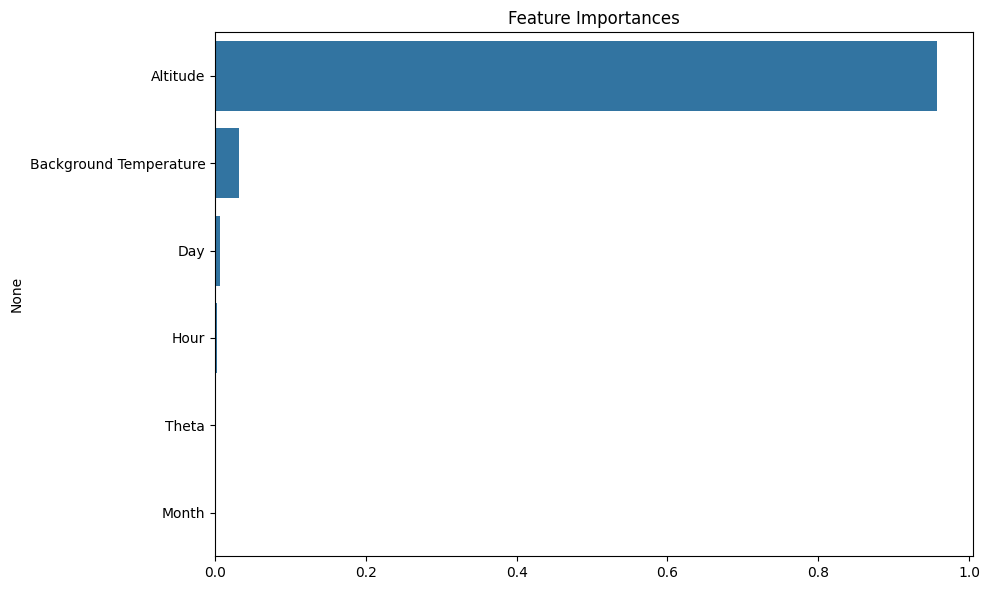

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("MSE:", mse)
print("R²:", r2)

# Feature importance
importances = model.feature_importances_
features = X.columns
indices = importances.argsort()[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=features[indices])
plt.title("Feature Importances")
plt.tight_layout()
plt.show()


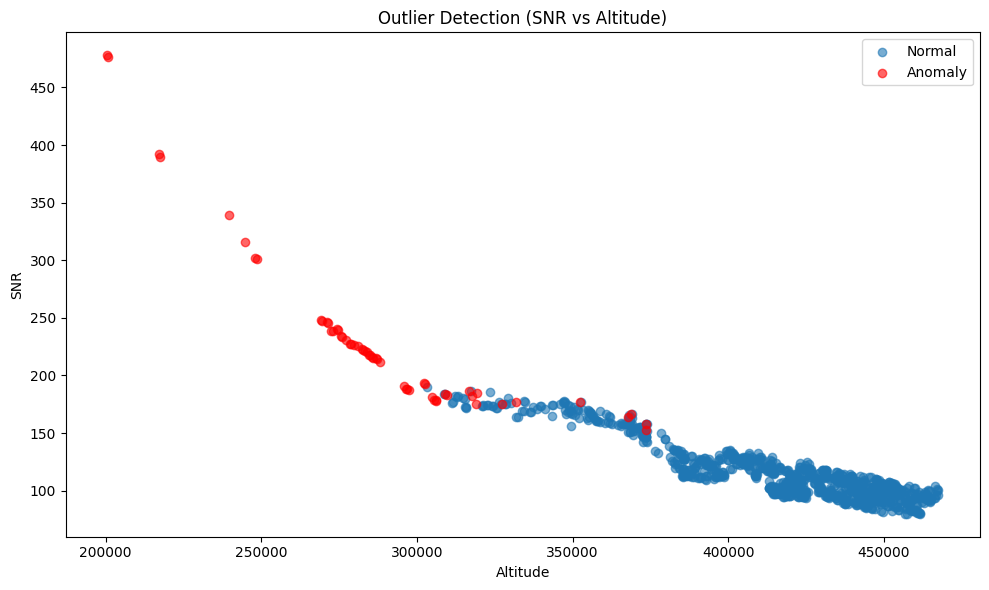

In [ ]:
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# Include SNR in the dataset for anomaly detection
X_outlier = X.copy()
X_outlier['SNR'] = y

# Fit Isolation Forest
iso = IsolationForest(contamination=0.05, random_state=42)
X_outlier['anomaly'] = iso.fit_predict(X_outlier)

# Visualize: normal vs anomaly
plt.figure(figsize=(10, 6))
normal = X_outlier[X_outlier['anomaly'] == 1]
anomaly = X_outlier[X_outlier['anomaly'] == -1]

plt.scatter(normal['Altitude'], normal['SNR'], label='Normal', alpha=0.6)
plt.scatter(anomaly['Altitude'], anomaly['SNR'], label='Anomaly', color='red', alpha=0.6)
plt.xlabel('Altitude')
plt.ylabel('SNR')
plt.title('Outlier Detection (SNR vs Altitude)')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
X_filtered = X_outlier[X_outlier['anomaly'] == 1].drop(columns='anomaly')
y_filtered = X_filtered.pop('SNR')


In [ ]:
outliers = X_outlier[X_outlier['anomaly'] == -1]

In [ ]:
X_outlier['anomaly_score'] = iso.decision_function(X_outlier.drop(columns=['anomaly']))

In [ ]:
# Identify outliers based on Isolation Forest results
outliers = df_cleaned.loc[X_outlier[X_outlier['anomaly'] == -1].index]

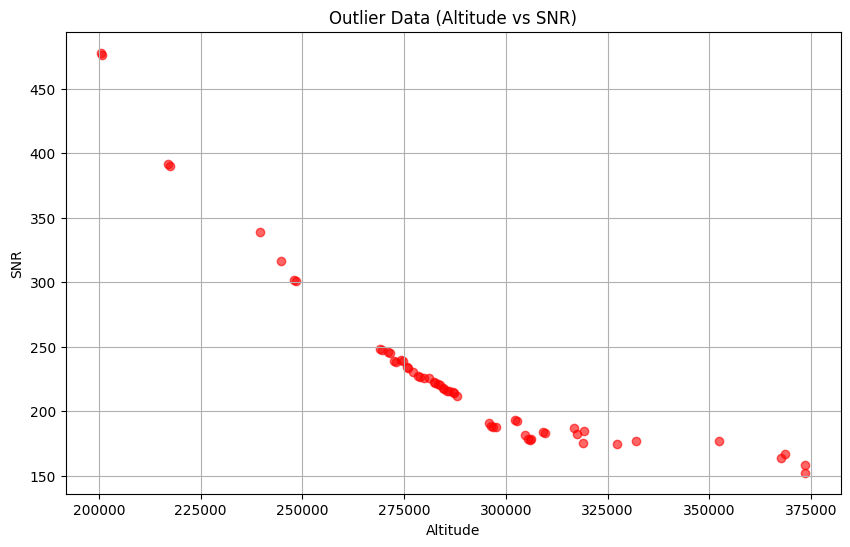

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(outliers['Altitude'], outliers['SNR'], color='red', alpha=0.6)
plt.xlabel('Altitude')
plt.ylabel('SNR')
plt.title('Outlier Data (Altitude vs SNR)')
plt.grid(True)
plt.show()


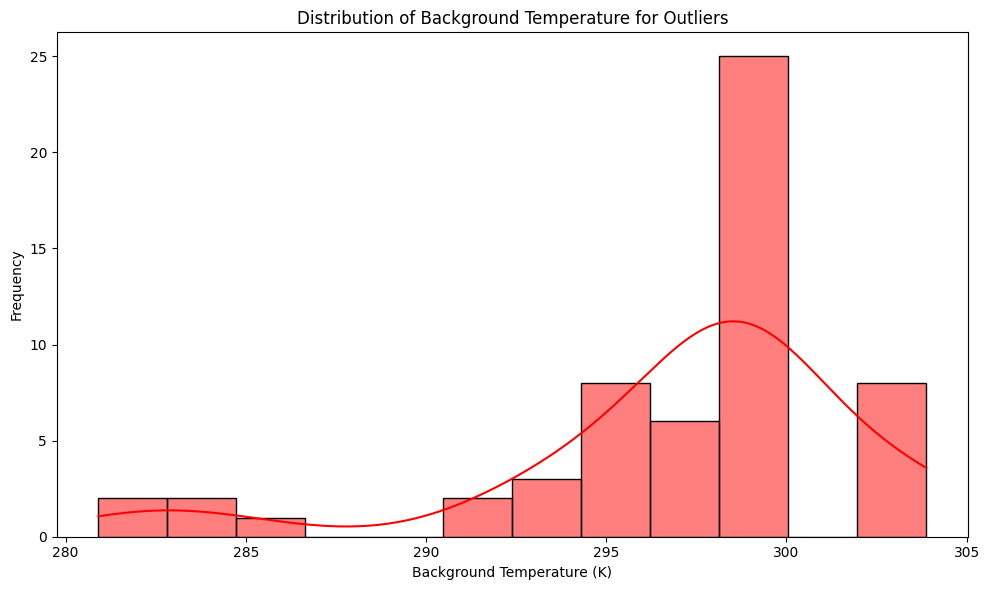

In [ ]:
# Example: Distribution of Background Temperature for outliers
plt.figure(figsize=(10, 6))
sns.histplot(outliers['Background Temperature'], kde=True, color='red')
plt.xlabel('Background Temperature (K)')
plt.ylabel('Frequency')
plt.title('Distribution of Background Temperature for Outliers')
plt.tight_layout()
plt.show()

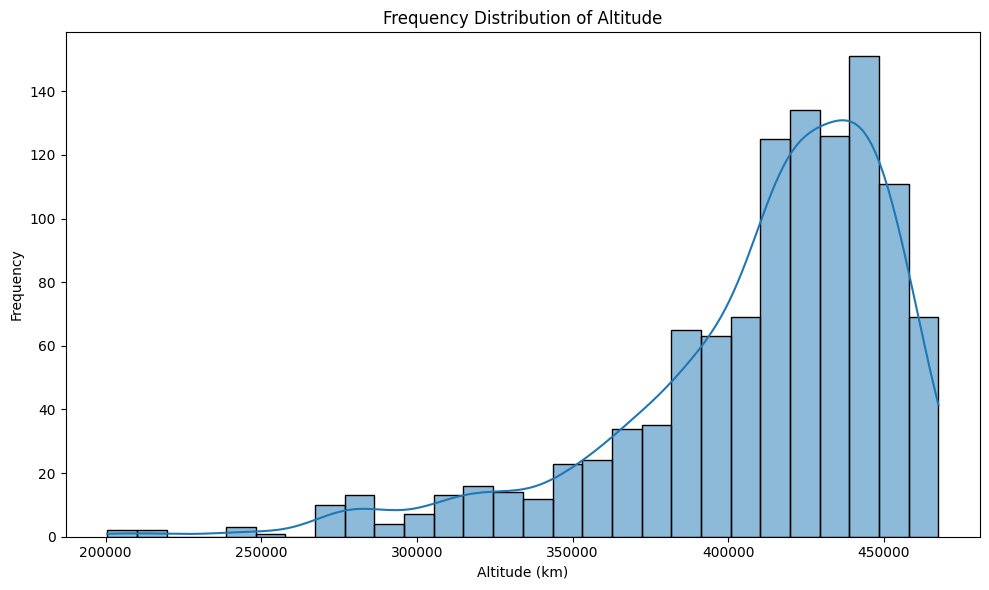

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Altitude'], kde=True)
plt.xlabel('Altitude (km)')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Altitude')
plt.tight_layout()
plt.show()

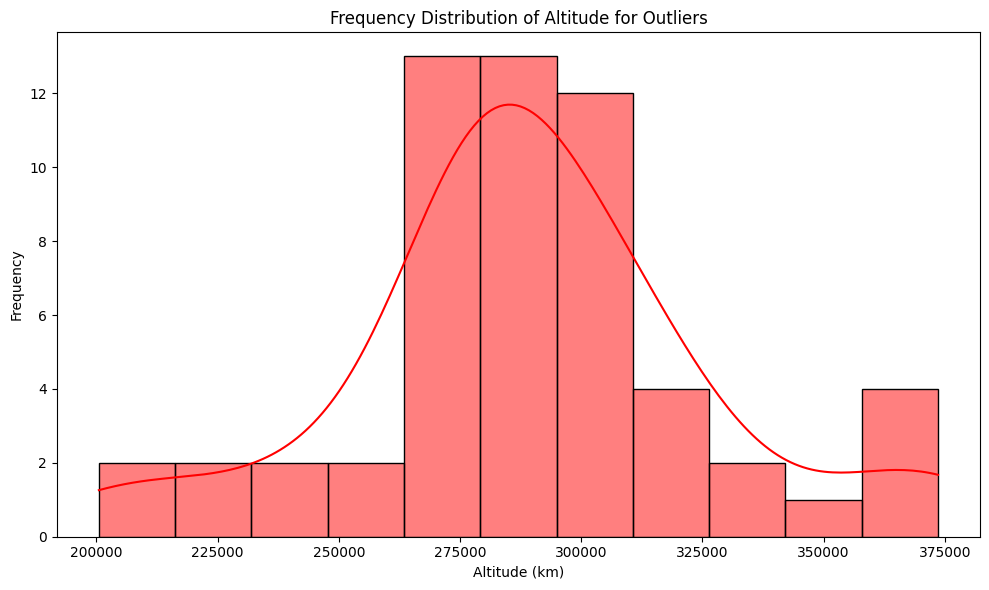

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(outliers['Altitude'], kde=True, color='red')
plt.xlabel('Altitude (km)')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Altitude for Outliers')
plt.tight_layout()
plt.show()

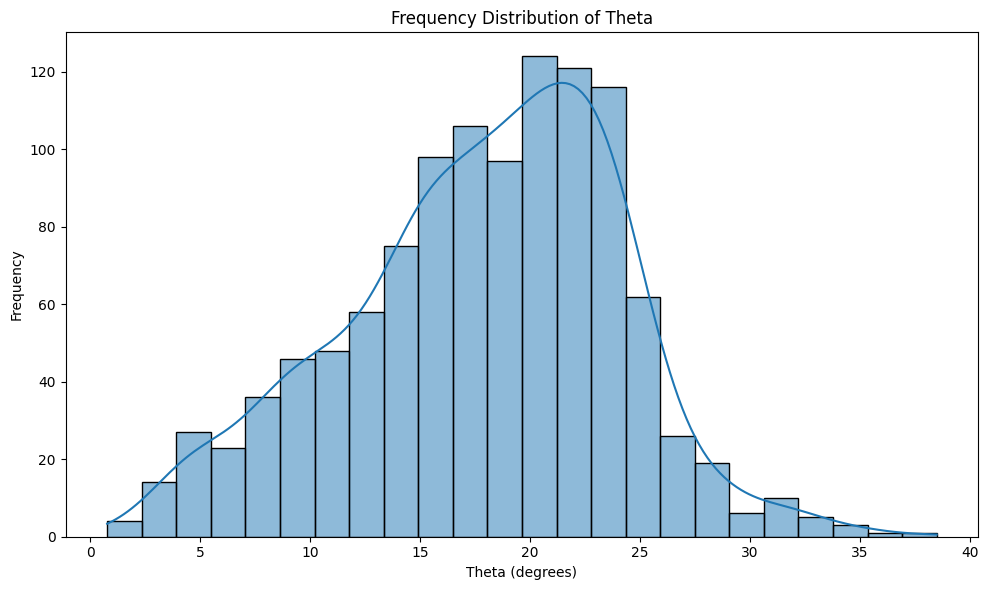

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Theta'], kde=True)
plt.xlabel('Theta (degrees)')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Theta')
plt.tight_layout()
plt.show()

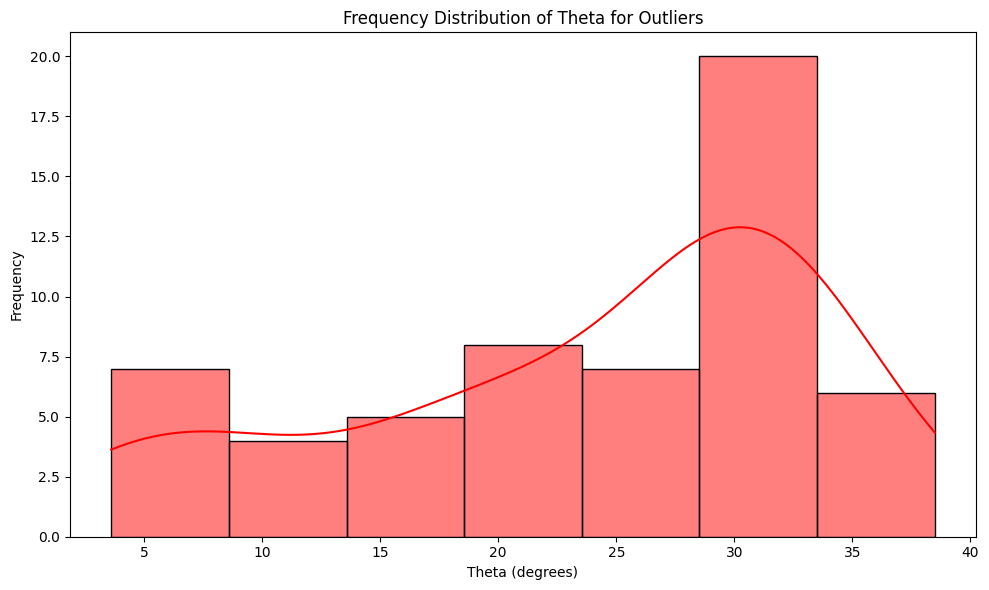

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(outliers['Theta'], kde=True, color='red')
plt.xlabel('Theta (degrees)')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Theta for Outliers')
plt.tight_layout()
plt.show()

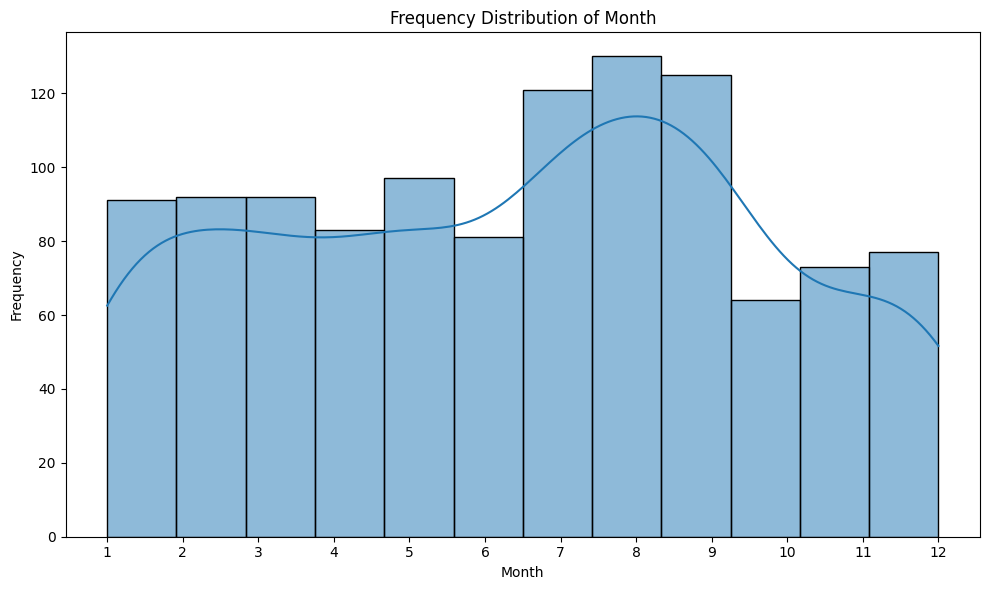

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Month'], kde=True, bins=12) # Assuming 'Month' is a numerical column
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Month')
plt.xticks(range(1, 13)) # Ensure all months are represented
plt.tight_layout()
plt.show()

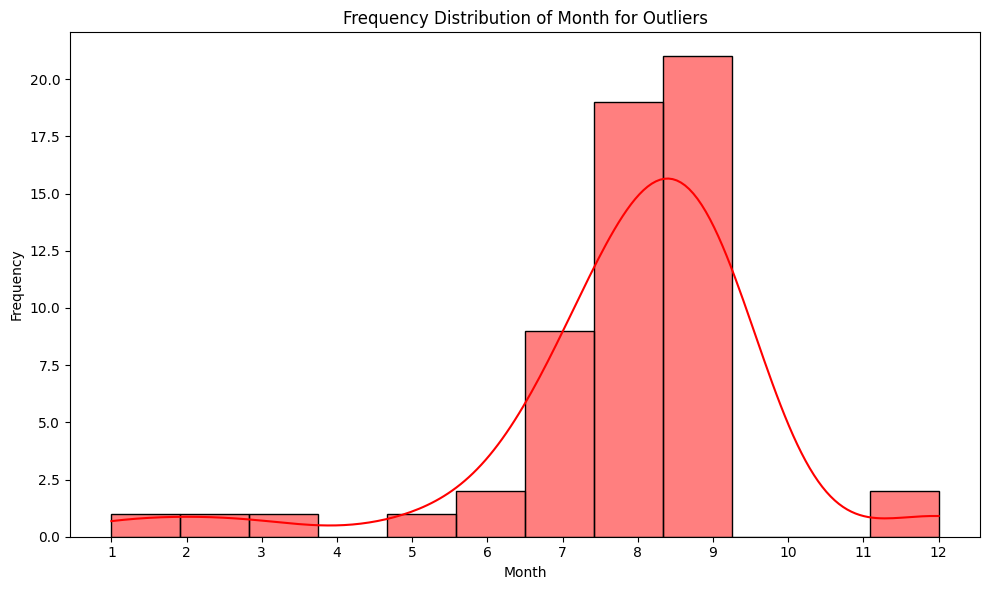


Frequency of Month in Outliers:
Month
1      1
2      1
3      1
5      1
6      2
7      9
8     19
9     21
12     2
Name: count, dtype: int64


In [ ]:
# Frequency of Month for Outliers
plt.figure(figsize=(10, 6))
sns.histplot(outliers['Month'], kde=True, bins=12, color='red')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Month for Outliers')
plt.xticks(range(1, 13)) # Ensure all months are represented
plt.tight_layout()
plt.show()

# Display the value counts of the 'Month' column in the outliers DataFrame
print("\nFrequency of Month in Outliers:")
print(outliers['Month'].value_counts().sort_index())

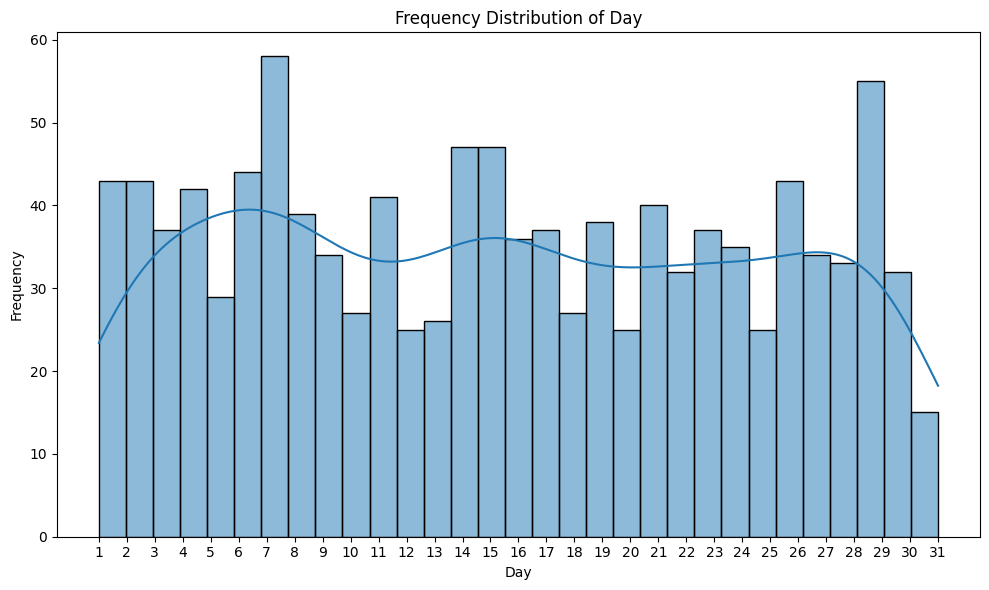

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Day'], kde=True, bins=31) # Assuming 'Day' is a numerical column
plt.xlabel('Day')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Day')
plt.xticks(range(1, 32)) # Ensure all possible days are represented
plt.tight_layout()
plt.show()

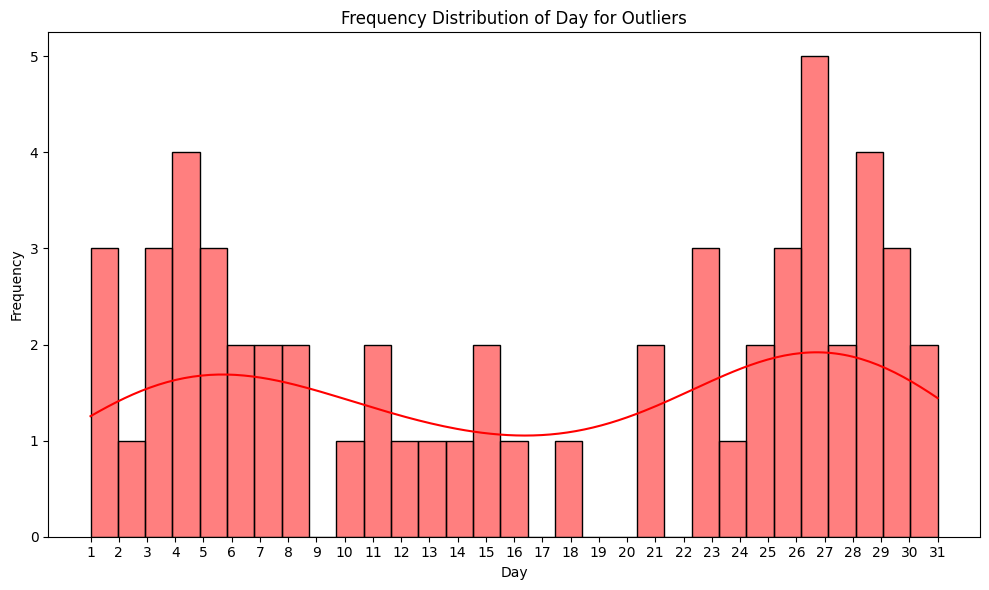

In [ ]:
# Frequency of Day for Outliers
plt.figure(figsize=(10, 6))
sns.histplot(outliers['Day'], kde=True, bins=31, color='red')
plt.xlabel('Day')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Day for Outliers')
plt.xticks(range(1, 32)) # Ensure all possible days are represented
plt.tight_layout()
plt.show()

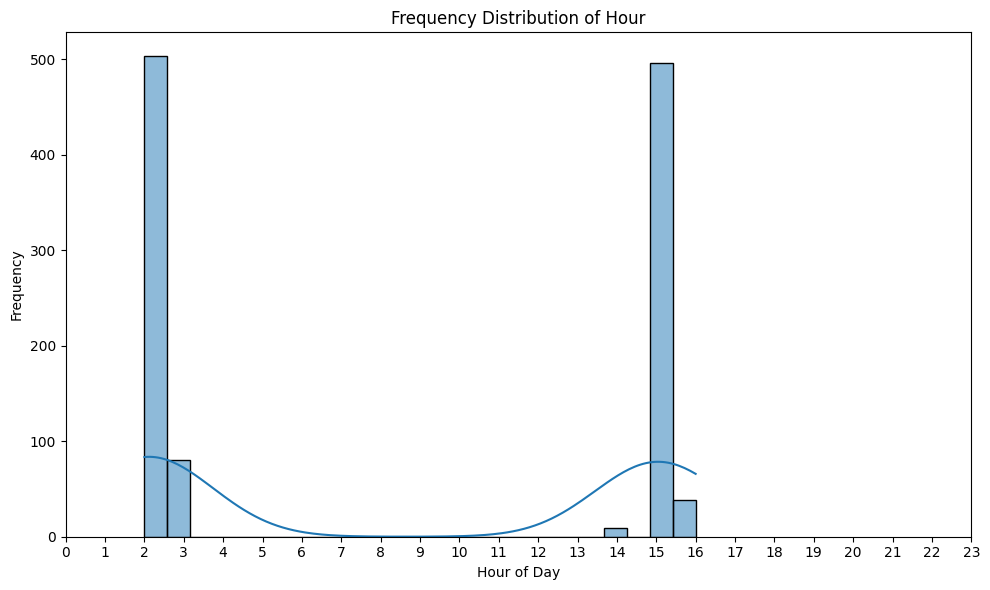

In [ ]:
# Frequency of Hour
plt.figure(figsize=(10, 6))
sns.histplot(df['Hour'].astype(str).str.split(':').str[0].astype(int), kde=True, bins=24)
plt.xlabel('Hour of Day')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Hour')
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()


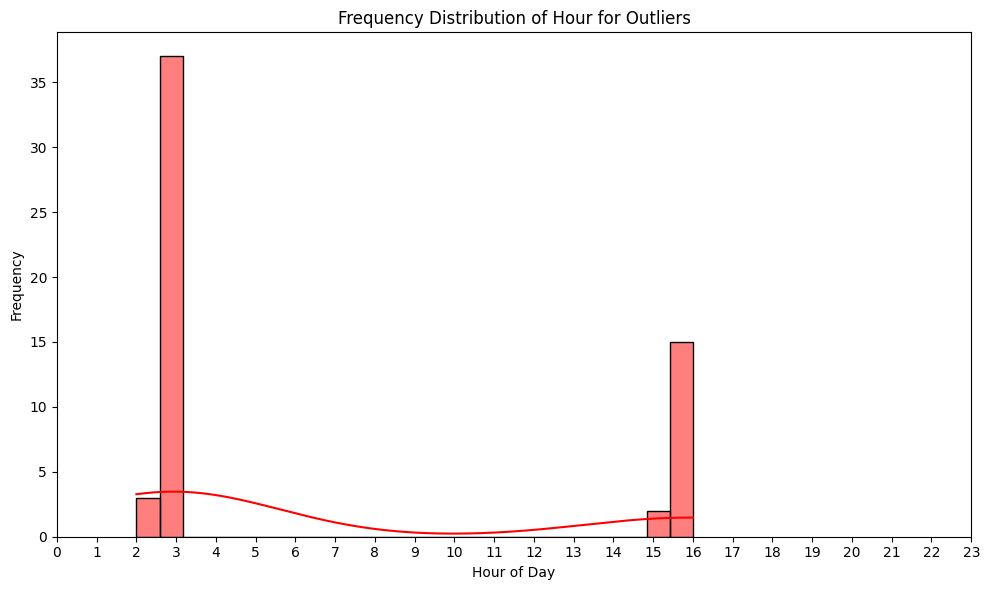

In [ ]:
# Frequency of Hour for Outliers
plt.figure(figsize=(10, 6))
sns.histplot(outliers['Hour'].astype(str).str.split(':').str[0].astype(int), kde=True, bins=24, color='red')
plt.xlabel('Hour of Day')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Hour for Outliers')
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()